<a href="https://colab.research.google.com/github/Hanchaeeun95/chaeeun95/blob/main/%EC%B5%9C%EC%A2%85.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**1st assignment**

**파이토치 불러오기**

In [6]:
import torch
print (torch.__version__)
import torch.optim as optim # 최적화 알고리즘
import torch.nn.functional as F # (define function) 인스턴스화 시킬 필요없이 사용 가능


2.0.1+cu118


**데이터 작업하기(가져오기)**

In [29]:
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets #FashionMNIST 데이터셋은 TorchVision Dataset에 포함되어 있음
from torchvision.transforms import ToTensor #ToTensor()를 하는 이유는 torchvision이 PIL Image 형태로만 입력을 받기 때문에 데이터 처리를 위해서 Tensor형으로 변환 필요함
import torchvision.transforms as transforms
mnist_transforms = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.Grayscale(num_output_channels=3),
    transforms.CenterCrop((227, 227)),# 227x227
    transforms.ToTensor()]) # ToTensor : PIL image or numpy.ndarray를 tensor로 바꿈


In [30]:
#공개 데이터셋에서 학습 데이터를 내려받습니다.
trainset = datasets.FashionMNIST(
    root ='/content/',
    train = True, download = True,
    transform =mnist_transforms
)

#공개 데이터셋에서 테스트 데이터를 내려받습니다.
testset = datasets.FashionMNIST(
    root ="data",
    train = False, download = True,
    transform =mnist_transforms
)

In [31]:
#DataLoader는 데이터 전체를 보관했다가 실제 모델 학습을 할 때 batch_size 크기만큼 데이터를 가져옴
train_loader = DataLoader(trainset, batch_size=64, shuffle=True)
test_loader = DataLoader(testset, batch_size=64, shuffle=False)

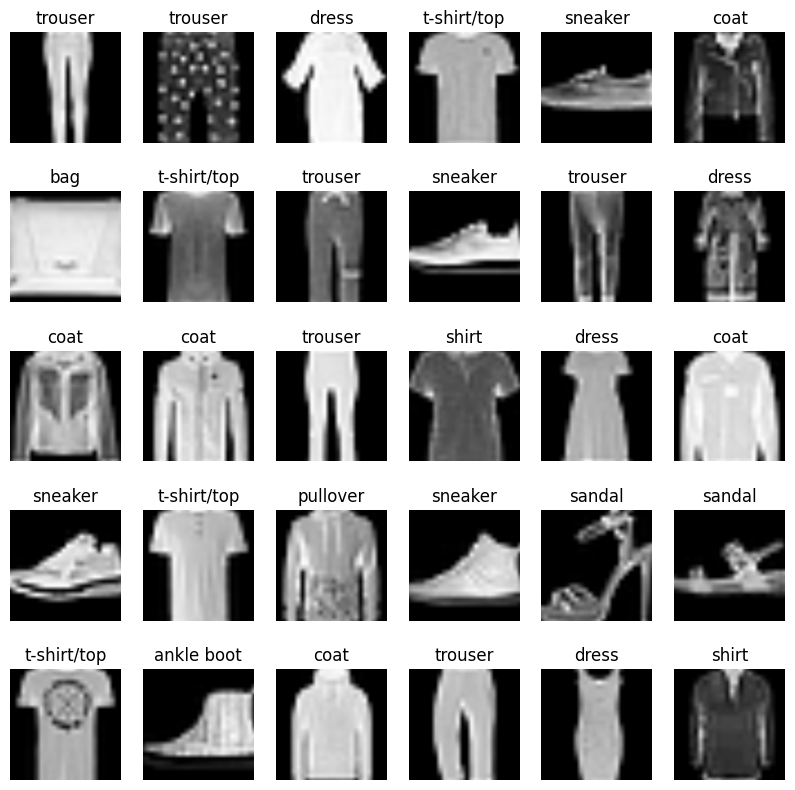

In [32]:
# 10개의 레이블 이미지 확인
import matplotlib.pyplot as plt

labels_map = {
    0: "t-shirt/top",
    1: "trouser",
    2: "pullover",
    3: "dress",
    4: "coat",
    5: "sandal",
    6: "shirt",
    7: "sneaker",
    8: "bag",
    9: "ankle boot",
}

figure = plt.figure(figsize=(10, 10))
cols, rows = 6, 5

for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(trainset), size=(1,)).item()
    img, label = trainset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(torch.permute(img, (1, 2, 0)), cmap='gray')
plt.show()


**신경망 구성하기**

In [33]:
device = (
    "cuda"
     if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device"
)

Using cuda device


In [34]:
import torch.nn as nn
epoch = 5 # 훈련 반복수
batch_size = 512 # 배치 크기

In [ ]:
class fashion_mnist_alexnet(nn.Module):
    def __init__(self):
        super(fashion_mnist_alexnet, self).__init__()
        # Image input_size=(3, 227, 227)
        self.layers = nn.Sequential(
            # input_size=(96, 55, 55)
            nn.Conv2d(in_channels=3, out_channels=96, kernel_size=(11, 11), stride=4, padding=0),
            nn.ReLU(),
            # input_size=(96, 27, 27)
            nn.MaxPool2d(kernel_size=3, stride=2),
            # input_size=(256, 27, 27)
            nn.Conv2d(in_channels=96, out_channels=256, kernel_size=(5, 5), stride=1, padding=2),
            nn.ReLU(),
            # input_size=(256, 13, 13)
            nn.MaxPool2d(kernel_size=3, stride=2),
            # input_size=(384, 13, 13)
            nn.Conv2d(in_channels=256, out_channels=384, kernel_size=(3, 3), stride=1, padding=1),
            nn.ReLU(),
            # input_size=(384, 13, 13)
            nn.Conv2d(in_channels=384, out_channels=384, kernel_size=(3, 3), stride=1, padding=1),
            nn.ReLU(),
            # input_size=(256, 13, 13)
            nn.Conv2d(in_channels=384, out_channels=256, kernel_size=(3, 3), stride=1, padding=1),
            nn.ReLU(),
            # input_size=(256, 6, 6)
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(in_features=256*6*6, out_features=4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(),
            nn.Linear(in_features=4096, out_features=10),
        )

    def forward(self, x):
        x = self.layers(x)
        x = x.view(-1, 256*6*6)
        x = self.classifier(x)
        return x


In [35]:
# #모델 정의하기
# class fashion_mnist_alexnet(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.conv1 = nn.Sequential(

#             nn.Conv2d(in_channels=3, out_channels=64, kernel_size=11, stride=4, padding=2),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=3, stride=3, ceil_mode=True),

#         )
#         self.conv2 = nn.Sequential(
#             nn.Conv2d(96, 256, 5, 1, 2), # in_channels: 96, out_channels: 256, kernel_size=5x5, stride=1, padding=2
#             # kernel 수 = 48x5x5 (드롭아웃을 사용했기 때문에 96/2=48) 형태의 256개
#             # 256x27x27
#             nn.ReLU(),
#             nn.MaxPool2d(3, 2) # 27 -> 13
#             # 256x13x13
#         )
#         self.conv3 = nn.Sequential(
#             nn.Conv2d(256, 384, 3, 1, 1),
#             nn.ReLU() # 13 유지
#             # 384x13x13
#         )
#         self.conv4 = nn.Sequential(
#             nn.Conv2d(384, 384, 3, 1, 1),
#             nn.ReLU() # 13 유지
#             # 384x13x13
#         )
#         self.conv5 = nn.Sequential(
#             nn.Conv2d(384, 256, 3, 1, 1),
#             nn.ReLU(),
#             nn.MaxPool2d(3, 2) # 13 -> 6
#             # 256x6x6
#         )

#         self.fc1 = nn.Linear(256 * 6 * 6, 4096)
#         self.fc2 = nn.Linear(4096, 4096)
#         self.fc3 = nn.Linear(4096, 10)

#     def forward(self, x): # input size = 3x227x227
#         out = self.conv1(x)
#         out = self.conv2(out)
#         out = self.conv3(out)
#         out = self.conv4(out)
#         out = self.conv5(out) # 64x4096x1x1
#         out = out.view(out.size(0), -1) # 64x4096

#         out = F.relu(self.fc1(out))
#         out = F.dropout(out, 0.5)
#         out = F.relu(self.fc2(out))
#         out = F.dropout(out, 0.5)
#         out = self.fc3(out)
#         out = F.log_softmax(out, dim=1)

#         return out



In [44]:
model = fashion_mnist_alexnet().to(device) # to()로 모델에 gpu 사용
criterion = F.nll_loss # nll_loss : negative log likelihood loss
optimizer = optim.Adam(model.parameters()) # model(신경망) 파라미터를 optimizer에 전달해줄 때 nn.Module의 parameters() 메소드를 사용

**모델 summary**

In [45]:
import torchsummary

model = fashion_mnist_alexnet().to(device) # to()로 모델에 gpu 사용

# AlexNet의 Image 입력 사이즈는 (3, 227, 227)
torchsummary.summary(model, input_size=(3, 227, 227), device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 55, 55]          34,944
              ReLU-2           [-1, 96, 55, 55]               0
         MaxPool2d-3           [-1, 96, 27, 27]               0
            Conv2d-4          [-1, 256, 27, 27]         614,656
              ReLU-5          [-1, 256, 27, 27]               0
         MaxPool2d-6          [-1, 256, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         885,120
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 384, 13, 13]       1,327,488
             ReLU-10          [-1, 384, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         884,992
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
          Dropout-14                 [-

**Train 정의**

In [46]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # enumberate() : 인덱스와 원소로 이루어진 튜플(tuple)을 만들어줌
        target = target.type(torch.LongTensor)
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad() # 항상 backpropagation 하기전에 미분(gradient)을 zero로 만들어주고 시작해야 한다.
        output = model(data)
        loss = criterion(output, target) # criterion = loss_fn
        loss.backward() # Computes the gradient of current tensor w.r.t. graph leaves
        optimizer.step() # step() : 파라미터를 업데이트함
        if (batch_idx + 1) % 30 == 0:
            print("Train Epoch:{} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

**Test 정의**

In [47]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target, reduction='sum').item()
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

        test_loss /= len(test_loader.dataset)  # -> mean
        print("\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n".format(
            test_loss, correct, len(test_loader.dataset), 100. * correct / len(test_loader.dataset)))
        print('='*50)

**학습 시작하기**

In [48]:
for epoch in range(1, epoch +1):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

Train Epoch:1 [1856/60000 (3%)]	Loss: -0.002446
Train Epoch:1 [3776/60000 (6%)]	Loss: -0.001861
Train Epoch:1 [5696/60000 (9%)]	Loss: -0.001444
Train Epoch:1 [7616/60000 (13%)]	Loss: -0.000344
Train Epoch:1 [9536/60000 (16%)]	Loss: -0.002350
Train Epoch:1 [11456/60000 (19%)]	Loss: -0.003528
Train Epoch:1 [13376/60000 (22%)]	Loss: -0.001848
Train Epoch:1 [15296/60000 (25%)]	Loss: -0.001722
Train Epoch:1 [17216/60000 (29%)]	Loss: -0.002026
Train Epoch:1 [19136/60000 (32%)]	Loss: -0.000872
Train Epoch:1 [21056/60000 (35%)]	Loss: -0.000635
Train Epoch:1 [22976/60000 (38%)]	Loss: -0.000714
Train Epoch:1 [24896/60000 (41%)]	Loss: -0.000444
Train Epoch:1 [26816/60000 (45%)]	Loss: -0.000839
Train Epoch:1 [28736/60000 (48%)]	Loss: -0.000426
Train Epoch:1 [30656/60000 (51%)]	Loss: -0.002679
Train Epoch:1 [32576/60000 (54%)]	Loss: -0.000048
Train Epoch:1 [34496/60000 (57%)]	Loss: -0.002392
Train Epoch:1 [36416/60000 (61%)]	Loss: -0.002659
Train Epoch:1 [38336/60000 (64%)]	Loss: -0.001541
Train Ep